#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.ndimage.filters import gaussian_filter1d

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [8]:
exps = ['comparison_pruning_2' , 'comparison_iterative_pruning_2', 'comparison_set_2']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [9]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,start_pruning_epoch,target_final_density,weight_decay,experiment_type,first_run,hebbian_grow,hebbian_prune_perc,iterative_pruning_schedule,pruning_early_stop,weight_prune_perc
0,0_target_final_density=0.1,0.95418,199,0.28814,0,0.89213,0.95418,0.8692,170,0.4052,...,1.0,0.10,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1_target_final_density=0.15,0.96978,193,0.25938,0,0.89539,0.96880,0.8789,160,0.3710,...,1.0,0.15,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2_target_final_density=0.2,0.97864,195,0.30640,0,0.89862,0.97856,0.8770,167,0.4360,...,1.0,0.20,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3_target_final_density=0.25,0.98144,195,0.29424,0,0.89384,0.98078,0.8779,190,0.4156,...,1.0,0.25,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4_target_final_density=0.3,0.98132,196,0.26182,0,0.88829,0.98000,0.8728,184,0.3888,...,1.0,0.30,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.shape

(56, 50)

In [11]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'augment_images', 'checkpoint_dir', 'data_dir', 'dataset_name',
       'device', 'end_pruning_epoch', 'input_size', 'learning_rate',
       'local_dir', 'lr_gamma', 'lr_milestones', 'lr_scheduler', 'model',
       'momentum', 'name', 'nesterov_momentum', 'network', 'num_classes',
       'on_perc', 'optim_alg', 'sparse_end', 'sparse_start',
       'start_pruning_epoch', 'target_final_density', 'weight_decay',
       'experiment_type', 'first_run', 'hebbian_grow', 'hebbian_prune_perc',
       'iterative_pruning_schedule', 'pruning_early_stop',
       'weight_prune_perc'],
      dtype='object')

In [17]:
df['model'].unique()

array(['PruningModel', 'IterativePruningModel', 'SET'], dtype=object)

In [24]:
# calculate density for each model
df.loc[df['model'] == 'PruningModel', 'density'] = df.loc[df['model'] == 'PruningModel', 'target_final_density']
df.loc[df['model'] == 'IterativePruningModel', 'density'] = df.loc[df['model'] == 'IterativePruningModel', 'target_final_density']
df.loc[df['model'] == 'SET', 'density'] = df.loc[df['model'] == 'SET', 'on_perc']

 ## Analysis

Experiment Details

In [25]:
# Did any  trials failed?
num_epochs = 200
df[df["epochs"]<num_epochs]["epochs"].count()

0

In [26]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(56, 51)

In [27]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


In [30]:
agg(['density', 'model'])

val_acc_max_epoch val_acc_max                    \
                                     round_mean         min    max   mean std   
density model                                                                   
0.10    IterativePruningModel               172       0.836  0.836  0.836 NaN   
        PruningModel                        170       0.869  0.869  0.869 NaN   
        SET                                 161       0.863  0.863  0.863 NaN   
0.15    IterativePruningModel               187       0.831  0.831  0.831 NaN   
        PruningModel                        160       0.879  0.879  0.879 NaN   
        SET                                 168       0.878  0.878  0.878 NaN   
0.20    IterativePruningModel               167       0.834  0.834  0.834 NaN   
        PruningModel                        167       0.877  0.877  0.877 NaN   
        SET                                 192       0.879  0.879  0.879 NaN   
0.25    IterativePruningModel               162       0.828  0.828  0.828 NaN   
        PruningModel                        190       0.878  0.878  0.878 NaN   
        SET                                 168       0.883  0.883  0.883 NaN   
0.30    IterativePruningModel               194       0.834  0.834  0.834 NaN   
        PruningModel                        184       0.873  0.873  0.873 NaN   
        SET                                 164       0.882  0.882  0.882 NaN   
0.35    IterativePruningModel               185       0.832  0.832  0.832 NaN   
        PruningModel                        196       0.881  0.881  0.881 NaN   
        SET                                 165       0.888  0.888  0.888 NaN   
0.40    IterativePruningModel               195       0.832  0.832  0.832 NaN   
        PruningModel                        165       0.883  0.883  0.883 NaN   
        SET                                 187       0.882  0.882  0.882 NaN   
0.45    IterativePruningModel               176       0.831  0.831  0.831 NaN   
        PruningModel                        185       0.877  0.877  0.877 NaN   
        SET                                 181       0.886  0.886  0.886 NaN   
0.50    IterativePruningModel               191       0.830  0.830  0.830 NaN   
        PruningModel                        166       0.883  0.883  0.883 NaN   
        SET                                 187       0.882  0.882  0.882 NaN   
0.55    IterativePruningModel               183       0.825  0.825  0.825 NaN   
        PruningModel                        168       0.884  0.884  0.884 NaN   
        SET                                 168       0.886  0.886  0.886 NaN   
0.60    IterativePruningModel               173       0.830  0.830  0.830 NaN   
        PruningModel                        192       0.882  0.882  0.882 NaN   
        SET                                 183       0.883  0.883  0.883 NaN   
0.65    IterativePruningModel               166       0.834  0.834  0.834 NaN   
        PruningModel                        195       0.880  0.880  0.880 NaN   
        SET                                 175       0.886  0.886  0.886 NaN   
0.70    IterativePruningModel               191       0.833  0.833  0.833 NaN   
        PruningModel                        172       0.884  0.884  0.884 NaN   
        SET                                 188       0.885  0.885  0.885 NaN   
0.75    IterativePruningModel               175       0.836  0.836  0.836 NaN   
        PruningModel                        174       0.883  0.883  0.883 NaN   
        SET                                 194       0.883  0.883  0.883 NaN   
0.80    IterativePruningModel               194       0.831  0.831  0.831 NaN   
        PruningModel                        172       0.885  0.885  0.885 NaN   
        SET                                 166       0.883  0.883  0.883 NaN   
0.85    IterativePruningModel               161       0.834  0.834  0.834 NaN   
        PruningModel                        180       0.886  

##### Plot accuracy over epochs

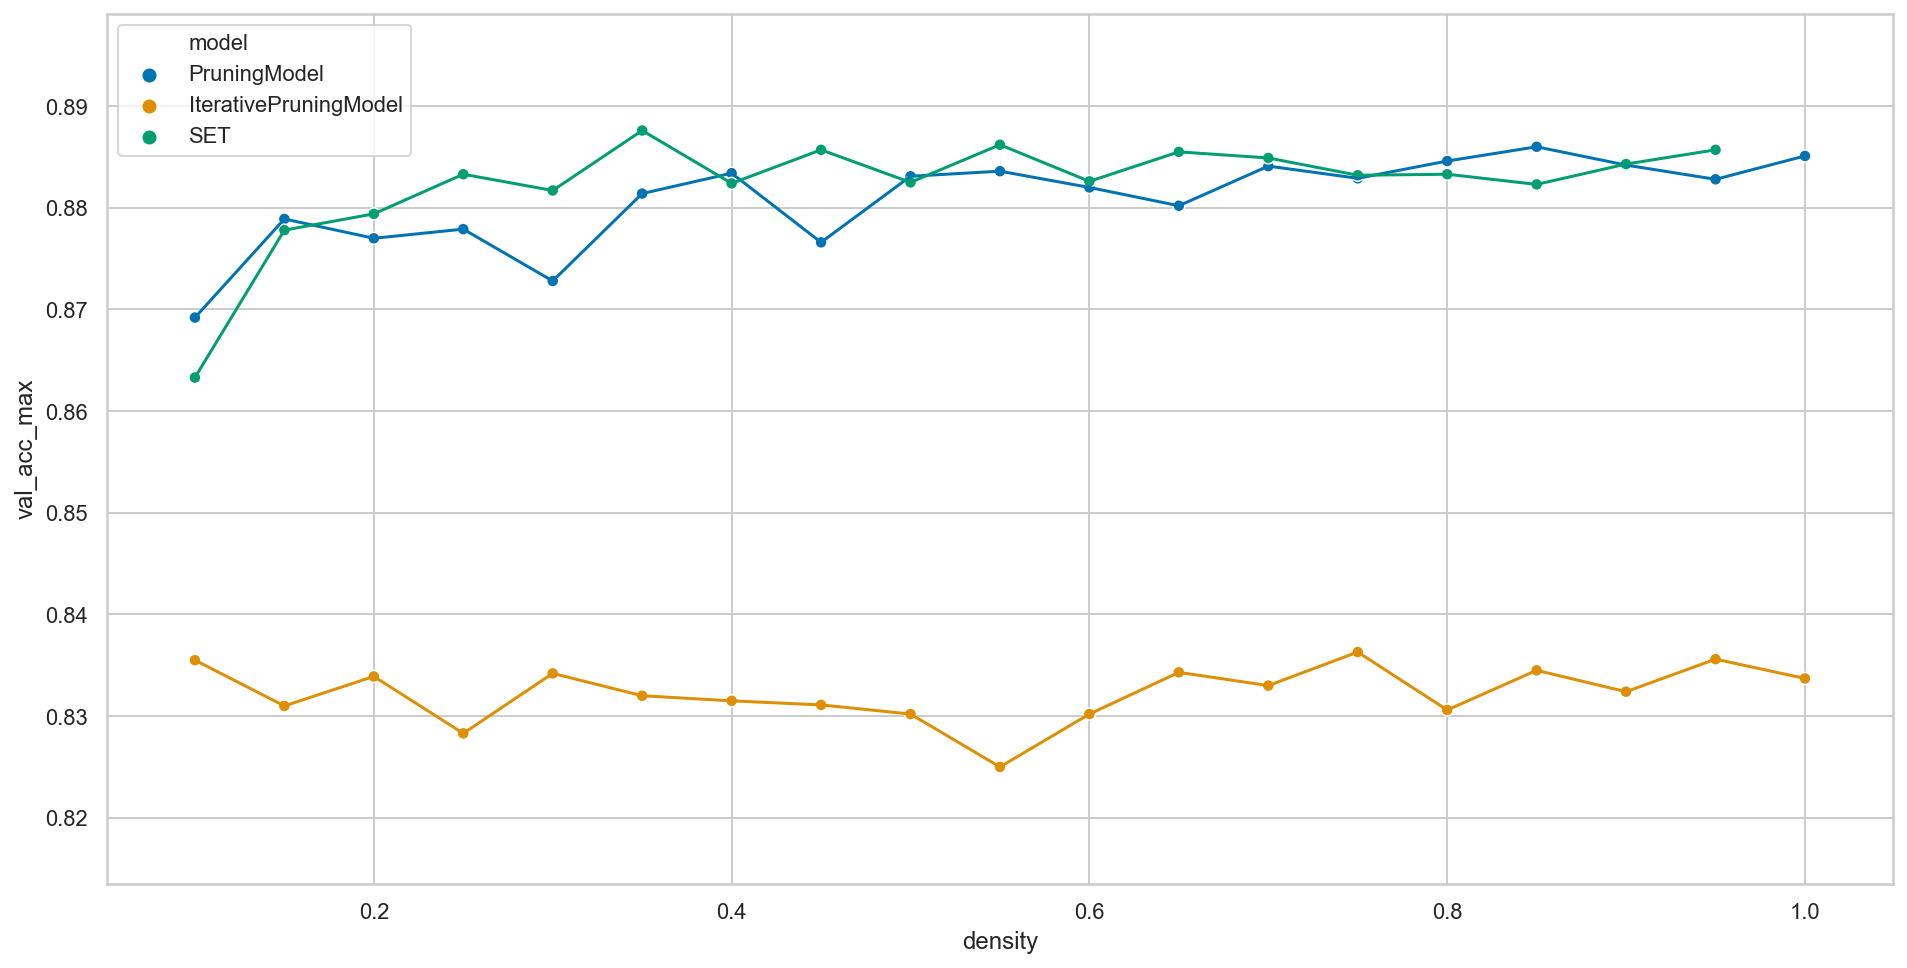

In [36]:
# translate model names
rcParams['figure.figsize'] = 16, 8
sns.scatterplot(data=df, x='density', y='val_acc_max', hue='model')
sns.lineplot(data=df, x='density', y='val_acc_max', hue='model', legend=False);